In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation import ReciprocalTransformer, PowerTransformer

import scipy.stats as stats

import myPreprocessors as mypp #nuestra librerías de transformaciones.

import joblib

In [195]:
dataTrain = pd.read_csv("train.csv")
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  14447 non-null  int64  
 1   longitude           14447 non-null  float64
 2   latitude            14447 non-null  float64
 3   housing_median_age  14447 non-null  int64  
 4   total_rooms         14447 non-null  int64  
 5   total_bedrooms      14310 non-null  float64
 6   population          14447 non-null  int64  
 7   households          14447 non-null  int64  
 8   median_income       14447 non-null  float64
 9   median_house_value  14447 non-null  float64
 10  ocean_proximity     14447 non-null  object 
dtypes: float64(5), int64(5), object(1)
memory usage: 1.2+ MB


In [196]:
dataTrain.dtypes

id                      int64
longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

#### 2. Exploracion de datos

In [197]:
NUMERICAL_VARS_WITH_NA =[col for col in dataTrain.columns if ((dataTrain[col].isnull().mean()>0) and ((dataTrain[col].dtype=='float') or (dataTrain[col].dtype=='int')))]
CATEGORICAL_VARS_WITH_NA=[col for col in dataTrain.columns if ((dataTrain[col].isnull().mean()>0) and (dataTrain[col].dtype=='object'))]
print(f'numerico: {NUMERICAL_VARS_WITH_NA}')
print(f'categorico: {CATEGORICAL_VARS_WITH_NA}')

numerico: ['total_bedrooms']
categorico: []


En este caso unicamente se tienen faltantes en las variables numericas siendo total bedrooms

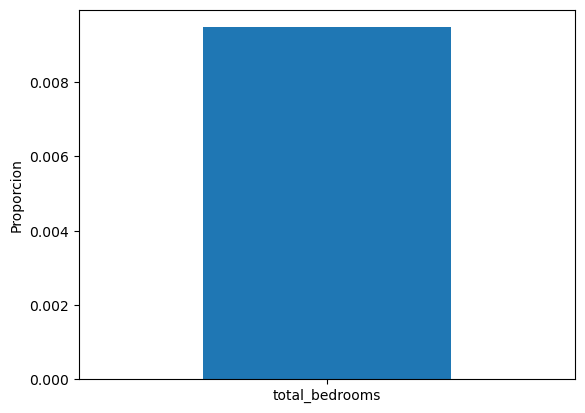

In [198]:

dataTrain[NUMERICAL_VARS_WITH_NA].isnull().mean().plot.bar()
plt.ylabel('Proporcion')
plt.xticks(rotation=0)
plt.show()


METODO 1: COMPLETE CASE ANALYSIS

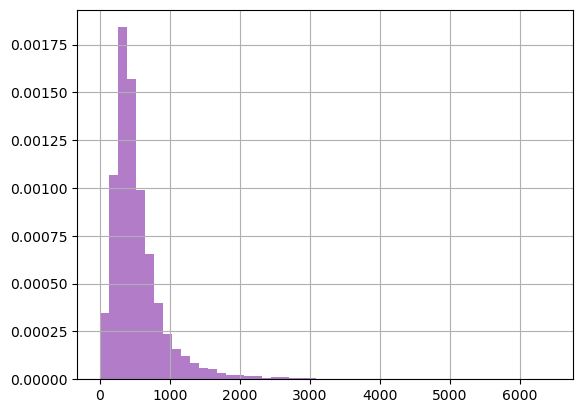

In [199]:
for c in NUMERICAL_VARS_WITH_NA:
    dataTrain[c].hist(bins=50,density=True,color='red',alpha=0.3)
    dataTrain[c].dropna().hist(bins=50,density=True,color='blue',alpha=0.3)
    plt.show()

Se puede observar que la distribucion mantiene su forma original, sin embargo debido a que en complete case analysis se quitan los registros que contengan faltantes el problema es que puede eliminarse algun dato importante en cualquiera de las otras variables o alguna categoria en especifica.

METODO 2: IMPUTACION MEDIA O MEDIANA

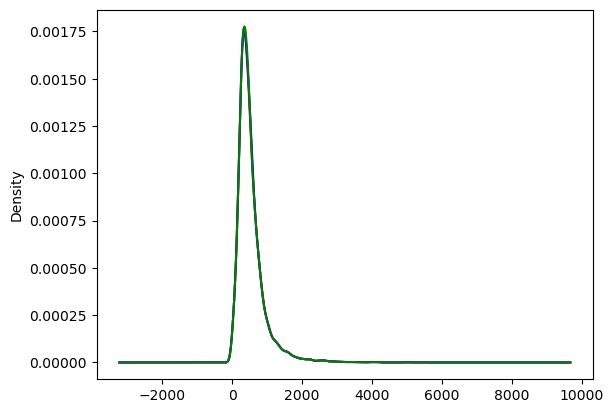

In [200]:
for c in NUMERICAL_VARS_WITH_NA:
    dataTrain[c+'_mean']=np.round(dataTrain[c].fillna(dataTrain[c].mean()))
    dataTrain[c+'_median']=np.round(dataTrain[c].fillna(dataTrain[c].median()))
    dataTrain[c].plot.density(color='red',label='Original')
    dataTrain[c+'_mean'].plot.density(color='blue',label='Media')
    dataTrain[c+'_median'].plot.density(color='green',label='Mediana')
    plt.show()

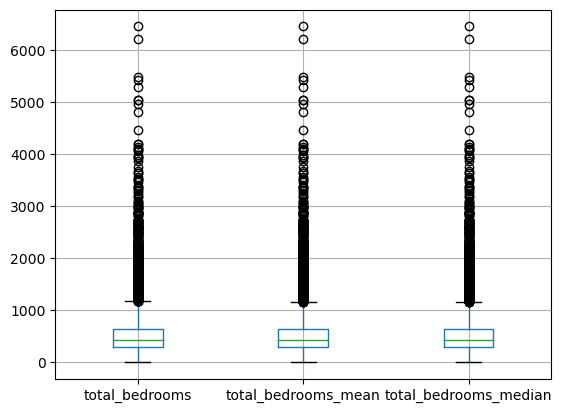

In [201]:
for c in NUMERICAL_VARS_WITH_NA:
    dataTrain[[c,c+'_mean',c+'_median']].boxplot()
    plt.show()

Dado que la proporción de faltantes para la variable numerica es menor al 5%, se opta por realizar una imputación de la media o mediana, observando el cambio que se genera en la distribución. El resultado muestra que la distribucion sigue siendo la misma al aplicar cualquiera de las imputaciones por lo que se opta por utilizar la imputacion de la media

METODO 3: IMPUTACION POR VALORES EXTREMOS IZQUIERDO O DERECHO

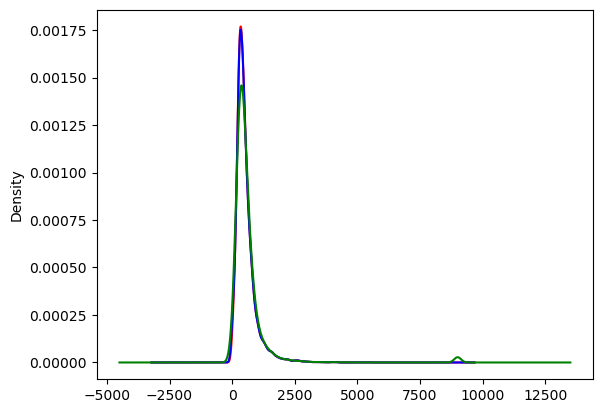

In [202]:
for c in NUMERICAL_VARS_WITH_NA:
    min=dataTrain[c].min()
    max=dataTrain[c].max()
    dataTrain[c+'_min']=np.round(dataTrain[c].fillna(0))
    dataTrain[c+'_max']=np.round(dataTrain[c].fillna(9000))
    dataTrain[c].plot.density(color='red',label='Original')
    dataTrain[c+'_min'].plot.density(color='blue',label='Min')
    dataTrain[c+'_max'].plot.density(color='green',label='Max')
    plt.show()

En este caso, conviene la imputacion con valor minimo dado que se asemeja a la distribucion original, no obstante puede observarse ligeras diferencias en lo que se refiere a la densidad en el punto 1. Motivo por el que la imputacion por media sigue siendo la mejor aproximacion 

METODO 4: IMPUTACION POR DISTRIBUCION NORMAL

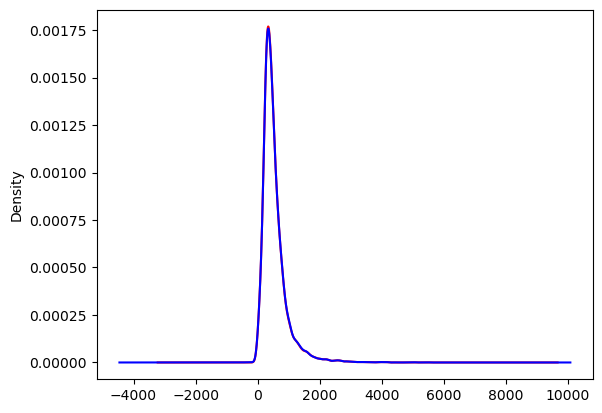

In [203]:
for c in NUMERICAL_VARS_WITH_NA:
    rng = np.random.default_rng(0)
    mu = dataTrain[c].mean()
    sd = dataTrain[c].std()
    filler = pd.Series(rng.normal(loc=mu, scale=sd, size=len(dataTrain)))
    dataTrain[c+'_dist'] = dataTrain[c].fillna(filler)
    dataTrain[c].plot.density(color='red',label='Original')
    dataTrain[c+'_dist'].plot.density(color='blue',label='Distribution')
    plt.show()

Se puede observar una ligera diferencian entre los valores de moda de ambas distribuciones, teniendo la distribucion original un poco más corrida hacia a la derecha a diferencia de la distribución con imputación de la normal que se tiene ligeramente a la izquierda (azul)

#### En conclusion se opta por imputacion por mediana a la unica variable numerica con datos faltantes en el dataset

In [204]:
dataTrain['total_bedrooms']=np.round(dataTrain['total_bedrooms'].fillna(dataTrain['total_bedrooms'].median()))

### Codificacion de variables categoricas

In [205]:
CATEGORICAL_VARS=[col for col in dataTrain.columns if (dataTrain[col].dtype=='object')]
CATEGORICAL_VARS

['ocean_proximity']

In [206]:
#categorias por columna, en este caso solamente se tiene una columna
for c in CATEGORICAL_VARS:
    print(f'{c}: \n \n {dataTrain[c].value_counts()}')

ocean_proximity: 
 
 <1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64


Debido a que solamente se trata de 5 categorias de solo una columna se opta por emplear ONE HOT ENCODING 

In [207]:
codificado=pd.get_dummies(dataTrain['ocean_proximity'])
dataTrain_temp=dataTrain.join(codificado)
dataTrain_temp

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,...,total_bedrooms_mean,total_bedrooms_median,total_bedrooms_min,total_bedrooms_max,total_bedrooms_dist,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,...,358.0,358.0,358.0,358.0,358.0,1,0,0,0,0
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,...,109.0,109.0,109.0,109.0,109.0,0,1,0,0,0
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,...,184.0,184.0,184.0,184.0,184.0,1,0,0,0,0
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,...,24.0,24.0,24.0,24.0,24.0,0,0,0,1,0
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,...,1352.0,1352.0,1352.0,1352.0,1352.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14442,557,-122.25,37.77,43,4329,1110.0,2086,1053,2.9750,243400.0,...,1110.0,1110.0,1110.0,1110.0,1110.0,0,0,0,1,0
14443,16090,-122.48,37.71,43,3850,1018.0,1497,829,3.5296,400000.0,...,1018.0,1018.0,1018.0,1018.0,1018.0,0,0,0,0,1
14444,9083,-118.17,34.69,12,4881,803.0,2188,724,4.1667,171900.0,...,803.0,803.0,803.0,803.0,803.0,0,1,0,0,0
14445,13138,-121.44,38.47,5,5666,1178.0,3139,1131,3.3608,108900.0,...,1178.0,1178.0,1178.0,1178.0,1178.0,0,1,0,0,0


In [208]:
def getColumnTypes(dataset):
# Descripcion: Esta funcion extrae el tipo de dominio de las columnas de un dataset
# Entradas: Pandas Dataframe
# Salida: Tupla con arreglo que contiene nombre de columnas
    continuas=[]
    discretas=[]
    categoricas=[]
    for col in dataset.columns:
        if((dataset[col].dtype=='int64')or(dataset[col].dtype=='float64')):
            if(len(dataset[col].unique())>30):
                continuas.append(col)
            else:
                discretas.append(col)
        else:
            categoricas.append(col)
    return discretas, continuas, categoricas

In [209]:
discretas, continuas, categoricas=getColumnTypes(dataTrain)
continuas

['id',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'total_bedrooms_mean',
 'total_bedrooms_median',
 'total_bedrooms_min',
 'total_bedrooms_max',
 'total_bedrooms_dist']

In [210]:
#validacion de no negativos o cero
for col in continuas:
    minimo=dataTrain[col].min()
    if minimo<=0:
        dataTrain[col]=dataTrain[col]+abs(minimo)+1
    else:
        dataTrain[col]=dataTrain[col]

In [211]:
for c in dataTrain[continuas].columns: 
    name=c+'_log'
    dataTrain[name]=np.log(dataTrain[c])
    name=c+'_inv'
    dataTrain[name]=(1/dataTrain[c])
    name=c+'_cuad'
    dataTrain[name]=(dataTrain[c]**2)
    name=c+'_coxbox'
    dataTrain[name],_=stats.boxcox(dataTrain[c])
    name=c+'_yeo'
    dataTrain[name],_=stats.yeojohnson(dataTrain[c])

In [212]:
for c in dataTrain[dataTrain.columns.difference(['ocean_proximity'])].columns:
    print(f'{c}\n resultado: {stats.shapiro(dataTrain[c])}')

households
 resultado: ShapiroResult(statistic=0.7378730773925781, pvalue=0.0)
households_coxbox
 resultado: ShapiroResult(statistic=0.9757348895072937, pvalue=1.1770907100328463e-43)
households_cuad
 resultado: ShapiroResult(statistic=0.28294670581817627, pvalue=0.0)
households_inv
 resultado: ShapiroResult(statistic=0.1047791838645935, pvalue=0.0)
households_log
 resultado: ShapiroResult(statistic=0.9362260103225708, pvalue=0.0)
households_yeo
 resultado: ShapiroResult(statistic=0.9762253165245056, pvalue=2.5223372357846707e-43)
housing_median_age
 resultado: ShapiroResult(statistic=0.978408932685852, pvalue=8.92767251621341e-42)
housing_median_age_coxbox
 resultado: ShapiroResult(statistic=0.9801951050758362, pvalue=2.0588017167706645e-40)
housing_median_age_cuad
 resultado: ShapiroResult(statistic=0.9165171384811401, pvalue=0.0)
housing_median_age_inv
 resultado: ShapiroResult(statistic=0.5147413611412048, pvalue=0.0)
housing_median_age_log
 resultado: ShapiroResult(statistic=0.901

c:\Users\50259\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Se concluye:

TRANSFORMACION INVERSA:

['longitude',
'housing_median_age',
'total_rooms',
'population',
'households',
'ocean_proximity']

TRANSFORMACION CUADRATICA:

['latitude',
'median_house_value',
'median_income',
'total_bedrooms',
'latitude']



In [213]:
d=pd.read_csv('train.csv')
list(d.columns)

['id',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

#### 4. Configuración y Construcción del Pipeline

In [214]:
dataTrain2 = pd.read_csv("train.csv")
dataTrain2.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


In [215]:
dataTrain2.dtypes

id                      int64
longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [216]:
X_train, X_test, y_train, y_test = train_test_split(
    dataTrain2.drop(['id','median_house_value'], axis=1),
    dataTrain2['median_house_value'],
    test_size=0.3,
    random_state=2022)

In [217]:

#Codificacion variable categorica
CATEGORICAL_VARS_ONE_HOT_ENCODING = ['ocean_proximity']

#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['total_bedrooms']

#Variables para transfomración inversa
NUMERICAL_INV_VARS = [  'longitude',
                        'housing_median_age',
                        'total_rooms',
                        'population',
                        'households']

#Variables para transfomración cuadratica
NUMERICAL_CUAD_VARS = ['latitude',
                        'total_bedrooms']

#Variables a utilzar en el entrenamiento
FEATURES = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'ocean_proximity'    ]

In [218]:
X_train = X_train[FEATURES]

In [219]:
y_train = np.power(y_train,2)
y_test = np.power(y_test,2)

In [220]:
for col in NUMERICAL_INV_VARS:
    minimo=dataTrain[col].min()
    if minimo<=0:
        dataTrain[col]=dataTrain[col]+abs(minimo)+1
    else:
        dataTrain[col]=dataTrain[col]

In [221]:
for col in NUMERICAL_CUAD_VARS:
    minimo=dataTrain[col].min()
    if minimo<=0:
        dataTrain[col]=dataTrain[col]+abs(minimo)+1
    else:
        dataTrain[col]=dataTrain[col]

In [264]:
housePrice_pipeline_v112022 = Pipeline([
    
    #=========== IMPUTACIONES ===============
    
    #1. Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #2. Imputación de variables numéricas
    ('median_imputation',
        MeanMedianImputer(imputation_method='median', variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    
    ('categorical_encoder',
        OneHotEncoder(top_categories=4, variables=CATEGORICAL_VARS_ONE_HOT_ENCODING)
    ),
    ######definnir
    
    #=============== TRANSFORMACIÓN DE VARIABLES CONTINUAS ============
    ('inv_transformer',
        ReciprocalTransformer(variables=NUMERICAL_INV_VARS)
    ),
    
    ('cuad_transformer',
        PowerTransformer(variables=NUMERICAL_CUAD_VARS, exp=2)
    ),
     #=============== SCALER ============
    ('scaler',
        RobustScaler()
    ),
    
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2022)
    )
])

In [265]:
housePrice_pipeline_v112022.fit(X_train, y_train)

c:\Users\50259\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.300e+24, tolerance: 3.922e+21
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('missing_indicator_numeric',
                 AddMissingIndicator(variables=['total_bedrooms'])),
                ('median_imputation',
                 MeanMedianImputer(variables=['total_bedrooms'])),
                ('categorical_encoder',
                 OneHotEncoder(top_categories=4,
                               variables=['ocean_proximity'])),
                ('inv_transformer',
                 ReciprocalTransformer(variables=['longitude',
                                                  'housing_median_age',
                                                  'total_rooms', 'population',
                                                  'households'])),
                ('cuad_transformer',
                 PowerTransformer(exp=2,
                                  variables=['latitude', 'total_bedrooms'])),
                ('scaler', RobustScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2022))])

In [266]:
X_test = X_test[FEATURES]

In [267]:
preds = housePrice_pipeline_v112022.predict(X_test)

In [268]:
preds2=abs(preds) 

In [273]:
rmseTest=np.sqrt(mean_squared_error(np.sqrt(y_test), np.sqrt(preds2)))
rmseTest

77445.08594401207

In [270]:
np.min(np.sqrt(y_train)), np.max(np.sqrt(y_train))

(14999.0, 500001.0)

In [271]:
rmseTest / (np.max(np.sqrt(y_train)) - np.min(np.sqrt(y_train)))

0.15967993110133993

In [274]:
#guardamos pipeline para uso en producción.
joblib.dump(housePrice_pipeline_v112022, 'housePrice_pipeline_v112022.pkl')

['housePrice_pipeline_v112022.pkl']

In [275]:
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']